In [1]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle

from multiprocess import Pool
from program.helper import *
from program.mlp_optimization import *
from program.utility import *

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import KFold

In [2]:
with open('../program/label_translator.pkl', 'rb') as pkl_file:
    label_translator = pickle.load(pkl_file)

## Pre-Processing

In [3]:
# Define a Composal of image transformation used for image load
transform_images = Compose([Resize((227, 227)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
train_data = ImageFolder("../data/train", transform=transform_images)
test_data = ImageFolder("../data/test", transform=transform_images)

In [6]:
dataloader_train = DataLoader(train_data, batch_size=150, shuffle=True, 
                              num_workers=24, pin_memory=True)
dataloader_test = DataLoader(test_data, batch_size=150, shuffle=True, 
                             num_workers=24, pin_memory=True)

## Optimization of MLP-Layer

These are results from a optuna study

Source: `mlp_optimization.py`

This scritp was run in a separate terminal

In [8]:
with open('../saved/best_trial.pkl', 'rb') as pkl_file:
    best_trial = pickle.load(pkl_file)

In [9]:
best_trial.params

{'n_layers': 3, 'fc1': 2379, 'fc2': 5592, 'fc3': 7864}

In [10]:
best_trial.value

0.24850193866760661

### Error Estimation of Metric

https://androidkt.com/pytorch-k-fold-cross-validation-using-dataloader-and-sklearn/

In [11]:
def plot_cv_metrics(metrics: dict):
    df = pd.DataFrame.from_dict(metrics).T
    df['train_precision'] = df['precision'].map(lambda x: x[0])
    df['test_precision'] = df['precision'].map(lambda x: x[1])
    df['train_accuracy'] = df['accuracy'].map(lambda x: x[0])
    df['test_accuracy'] = df['accuracy'].map(lambda x: x[1])
    df = df.drop(['accuracy', 'precision'], axis=1)
    df = df.reset_index()
    df = df.melt(id_vars='index',var_name='name', value_name='score' )
    
    fig = plt.subplots(figsize=(18, 4))
    sns.set_palette('Paired', 4)
    sns.set_style('whitegrid')
    plt.subplot(1,2,1)
    tmp = df[df['name'].str.contains('train')]
    p = sns.boxplot(data=tmp, x='name', y='score')
    p.set_title('Error Estimation of Metrics on Trainset', loc='left')
    p.set_xticklabels(['Precision', 'Accuracy'])
    p.set_xlabel('')
    p.set_ylabel('Score')

    plt.subplot(1,2,2)
    tmp = df[df['name'].str.contains('test')]
    p = sns.boxplot(data=tmp, x='name', y='score' ,width=.5)
    p.set_title('Error Estimation of Metrics on Testset', loc='left')
    p.set_xticklabels(['Precision', 'Accuracy'])
    p.set_xlabel('')
    p.set_ylabel('Score')

    plt.show()
    return p

In [12]:
from networks import FlatAlexNetOpt

In [13]:
opt_model = FlatAlexNetOpt(n_classes=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(opt_model.parameters(),  lr=.0045, momentum=.95)
dtype = torch.float32
print_total_params(opt_model)

Trainable Parameters: 72756991


In [22]:
metrics = train_network_kfold(model=opt_model, train_data=train_data, 
                              test_data=test_data, criterion=criterion, 
                              optimizer=optimizer, n_epochs=100, 
                              k_folds=5, batch_sizes=150, epsilon=10)

==================== Fold 0 ====================


Epoch: 1 // Running Loss: 501.972 // Accuracy: 0 : 100%|██████████| 151/151 [00:18<00:00,  8.32it/s]
Epoch: 2 // Running Loss: 481.97 // Accuracy: 0.046 : 100%|██████████| 151/151 [00:17<00:00,  8.49it/s] 
Epoch: 3 // Running Loss: 456.064 // Accuracy: 0.073 : 100%|██████████| 151/151 [00:18<00:00,  8.37it/s]
Epoch: 4 // Running Loss: 440.466 // Accuracy: 0.097 : 100%|██████████| 151/151 [00:17<00:00,  8.41it/s]
Epoch: 5 // Running Loss: 431.917 // Accuracy: 0.113 : 100%|██████████| 151/151 [00:18<00:00,  8.36it/s]
Epoch: 6 // Running Loss: 422.855 // Accuracy: 0.125 : 100%|██████████| 151/151 [00:18<00:00,  8.37it/s]
Epoch: 7 // Running Loss: 416.567 // Accuracy: 0.137 : 100%|██████████| 151/151 [00:18<00:00,  8.31it/s]
Epoch: 8 // Running Loss: 407.706 // Accuracy: 0.146 : 100%|██████████| 151/151 [00:18<00:00,  8.26it/s]
Epoch: 9 // Running Loss: 398.867 // Accuracy: 0.155 : 100%|██████████| 151/151 [00:18<00:00,  8.34it/s]
Epoch: 10 // Running Loss: 391.511 // Accuracy: 0.163 : 100

Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 38/38 [00:05<00:00,  7.25it/s]


==================== Fold 1 ====================


Epoch: 1 // Running Loss: 501.841 // Accuracy: 0 : 100%|██████████| 151/151 [00:18<00:00,  8.36it/s]
Epoch: 2 // Running Loss: 481.226 // Accuracy: 0.042 : 100%|██████████| 151/151 [00:18<00:00,  8.27it/s]
Epoch: 3 // Running Loss: 456.405 // Accuracy: 0.071 : 100%|██████████| 151/151 [00:18<00:00,  8.27it/s]
Epoch: 4 // Running Loss: 443.499 // Accuracy: 0.094 : 100%|██████████| 151/151 [00:18<00:00,  8.36it/s]
Epoch: 5 // Running Loss: 433.651 // Accuracy: 0.11 : 100%|██████████| 151/151 [00:18<00:00,  8.29it/s]
Epoch: 6 // Running Loss: 425.838 // Accuracy: 0.122 : 100%|██████████| 151/151 [00:18<00:00,  8.32it/s]
Epoch: 7 // Running Loss: 417.65 // Accuracy: 0.134 : 100%|██████████| 151/151 [00:18<00:00,  8.28it/s] 
Epoch: 8 // Running Loss: 410.477 // Accuracy: 0.143 : 100%|██████████| 151/151 [00:18<00:00,  8.33it/s]
Epoch: 9 // Running Loss: 403.044 // Accuracy: 0.151 : 100%|██████████| 151/151 [00:18<00:00,  8.37it/s]
Epoch: 10 // Running Loss: 396.108 // Accuracy: 0.159 : 100%

Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 38/38 [00:05<00:00,  7.34it/s]


==================== Fold 2 ====================


Epoch: 1 // Running Loss: 501.944 // Accuracy: 0 : 100%|██████████| 151/151 [00:18<00:00,  8.32it/s]
Epoch: 2 // Running Loss: 479.441 // Accuracy: 0.048 : 100%|██████████| 151/151 [00:18<00:00,  8.27it/s]
Epoch: 3 // Running Loss: 452.702 // Accuracy: 0.078 : 100%|██████████| 151/151 [00:17<00:00,  8.45it/s]
Epoch: 4 // Running Loss: 442.165 // Accuracy: 0.101 : 100%|██████████| 151/151 [00:18<00:00,  8.29it/s]
Epoch: 5 // Running Loss: 433.688 // Accuracy: 0.116 : 100%|██████████| 151/151 [00:18<00:00,  8.27it/s]
Epoch: 6 // Running Loss: 425.684 // Accuracy: 0.128 : 100%|██████████| 151/151 [00:18<00:00,  8.36it/s]
Epoch: 7 // Running Loss: 416.018 // Accuracy: 0.138 : 100%|██████████| 151/151 [00:18<00:00,  8.31it/s]
Epoch: 8 // Running Loss: 408.486 // Accuracy: 0.147 : 100%|██████████| 151/151 [00:18<00:00,  8.22it/s]
Epoch: 9 // Running Loss: 401.151 // Accuracy: 0.155 : 100%|██████████| 151/151 [00:18<00:00,  8.32it/s]
Epoch: 10 // Running Loss: 395.226 // Accuracy: 0.163 : 100

Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 38/38 [00:05<00:00,  7.21it/s]


==================== Fold 3 ====================


Epoch: 1 // Running Loss: 501.954 // Accuracy: 0 : 100%|██████████| 151/151 [00:18<00:00,  8.35it/s]
Epoch: 2 // Running Loss: 480.209 // Accuracy: 0.041 : 100%|██████████| 151/151 [00:18<00:00,  8.29it/s]
Epoch: 3 // Running Loss: 454.567 // Accuracy: 0.071 : 100%|██████████| 151/151 [00:18<00:00,  8.28it/s]
Epoch: 4 // Running Loss: 441.296 // Accuracy: 0.096 : 100%|██████████| 151/151 [00:18<00:00,  8.32it/s]
Epoch: 5 // Running Loss: 432.413 // Accuracy: 0.112 : 100%|██████████| 151/151 [00:18<00:00,  8.27it/s]
Epoch: 6 // Running Loss: 424.962 // Accuracy: 0.125 : 100%|██████████| 151/151 [00:18<00:00,  8.33it/s]
Epoch: 7 // Running Loss: 419.096 // Accuracy: 0.136 : 100%|██████████| 151/151 [00:18<00:00,  8.16it/s]
Epoch: 8 // Running Loss: 409.906 // Accuracy: 0.145 : 100%|██████████| 151/151 [00:18<00:00,  8.29it/s]
Epoch: 9 // Running Loss: 401.152 // Accuracy: 0.153 : 100%|██████████| 151/151 [00:18<00:00,  8.25it/s]
Epoch: 10 // Running Loss: 394.73 // Accuracy: 0.162 : 100%

Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 38/38 [00:05<00:00,  7.22it/s]


==================== Fold 4 ====================


Epoch: 1 // Running Loss: 501.908 // Accuracy: 0 : 100%|██████████| 151/151 [00:18<00:00,  8.19it/s]
Epoch: 2 // Running Loss: 478.537 // Accuracy: 0.044 : 100%|██████████| 151/151 [00:18<00:00,  8.30it/s]
Epoch: 3 // Running Loss: 453.098 // Accuracy: 0.074 : 100%|██████████| 151/151 [00:18<00:00,  8.21it/s]
Epoch: 4 // Running Loss: 441.621 // Accuracy: 0.098 : 100%|██████████| 151/151 [00:18<00:00,  8.28it/s]
Epoch: 5 // Running Loss: 431.037 // Accuracy: 0.114 : 100%|██████████| 151/151 [00:18<00:00,  8.26it/s]
Epoch: 6 // Running Loss: 424.939 // Accuracy: 0.127 : 100%|██████████| 151/151 [00:18<00:00,  8.28it/s]
Epoch: 7 // Running Loss: 415.707 // Accuracy: 0.137 : 100%|██████████| 151/151 [00:18<00:00,  8.28it/s]
Epoch: 8 // Running Loss: 410.808 // Accuracy: 0.146 : 100%|██████████| 151/151 [00:18<00:00,  8.27it/s]
Epoch: 9 // Running Loss: 401.419 // Accuracy: 0.154 : 100%|██████████| 151/151 [00:18<00:00,  8.28it/s]
Epoch: 10 // Running Loss: 396.671 // Accuracy: 0.161 : 100

Calculating Metrics ...


Calculate Acc. on Test Data: 100%|██████████| 38/38 [00:05<00:00,  6.66it/s]


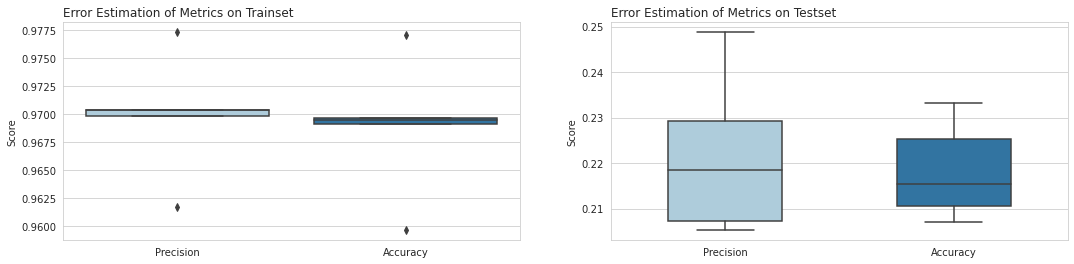

<Figure size 432x288 with 0 Axes>

In [23]:
plot = plot_cv_metrics(metrics)
plt.savefig('FlatAlexNetOpt_cv_error')

In [24]:
metrics

{0: {'accuracy': [0.9691095769162683, 0.21543636041777306],
  'precision': [0.9698071344237552, 0.20733203271397485]},
 1: {'accuracy': [0.9770755885997522, 0.2331386086032926],
  'precision': [0.977285169865112, 0.22921237645610074]},
 2: {'accuracy': [0.9696848999822978, 0.20693928128872366],
  'precision': [0.9703267516352565, 0.2052948846315729]},
 3: {'accuracy': [0.9694636218799788, 0.21047973092582759],
  'precision': [0.9703234156129243, 0.21844476210327407]},
 4: {'accuracy': [0.9596831297574792, 0.225349619401664],
  'precision': [0.9617201356675508, 0.24876754218602945]}}